In [146]:
import sys
import os
#import torch
import zarr
import fsspec
import lilio
import warnings
import xarray as xr
import numpy as np
import pandas as pd
import pyarrow as pa
import matplotlib.pyplot as plt

#from torch import nn
from pathlib import Path
from scipy.stats import pearsonr, spearmanr
from sklearn.linear_model import LinearRegression

sys.path.append(os.path.expanduser('~/Documents/Medley'))
from scripts.prepare_monthly_ts_data import get_monthly_data

In [147]:
warnings.simplefilter('ignore',category=RuntimeWarning)

### Defining predictand
TODO: also eastern Europe. And extract both WSD and EOBS

In [148]:
# blocks to include and exclude. Lonmin, latmin, lonmax, latmax
include = {'iberia':(-9.8,35.98,3.6,43.8),
          'france_italy':(4,43,13.4,45.63)}
exclude = {'islands':(0.79,35.2,4.6,40.4),
          'north_africa':(-1.450,34.457,11.217,36.972)}

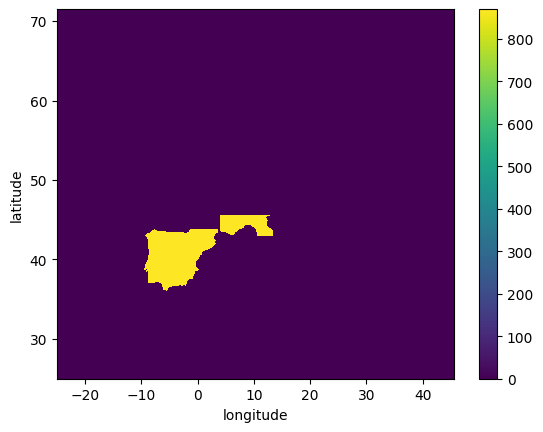

In [149]:
rrmon = xr.open_zarr('/scistor/ivm/jsn295/Medi/monthly/rr_mon_ens_mean_0.1deg_reg_v26.0e.zarr/')['rr']
example = rrmon.isel(time = 0, drop =True)
mask = xr.DataArray(np.full_like(example, 0), coords = example.coords)
def set_subset_to(lonmin, latmin, lonmax, latmax, array, value):
    lons = array.sel(longitude = slice(lonmin, lonmax)).longitude
    lats = array.sel(latitude = slice(latmin, latmax)).latitude
    array.loc[lats,lons] = value # cannot do .sel based assignment
for args in include.values():
    set_subset_to(*args, array = mask, value = 1)
for args in exclude.values():
    set_subset_to(*args, array = mask, value = 0)
count = xr.where(mask,rrmon,np.nan).count('time').compute()
count.plot()

In [150]:
# Precip trends per season/month?

In [151]:
df = get_monthly_data().to_pandas()
target = xr.where(mask,rrmon,np.nan).mean(['longitude','latitude']).compute().to_dataframe(name = 'rrmon')
target.columns = pd.MultiIndex.from_tuples([('rrmon',0,'EOBS')], names = df.columns.names)
df = df.loc[target.index,:]

In [29]:
def estimate_gmstcoef(series):
    x = df.loc[series.index, 'gmst']
    ln = LinearRegression()
    ln.fit(X = x, y = series.squeeze())
    return ln.coef_[0]

In [33]:
mcoefs = target.groupby(target.index.month).apply(estimate_gmstcoef)
mcoefs.name = 'trend mm/degree'

<Axes: xlabel='time'>

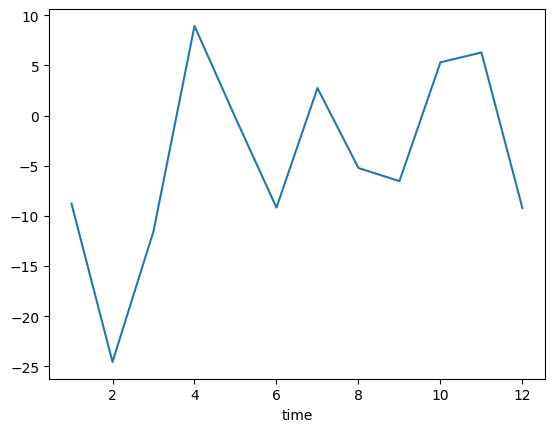

In [34]:
mcoefs.plot()

In [36]:
# April seems to have been wettening.
#target.loc[target.index.month == 4,:].plot()

## trends in predictors

In [159]:
cal = lilio.Calendar(anchor = '12-01')
#cal.add_intervals("target", length="1M", gap = '0M')
cal.add_intervals("precursor", length="3M", n=1, gap = '-3M') # Fully co-occurring
#cal.add_intervals("precursor", length="1M", n=3, gap = '0M')
cal.map_years(start=1949, end=2023)

Calendar(
    anchor='12-01',
    allow_overlap=False,
    mapping=('years', 1949, 2023),
    intervals=[
        Interval(role='precursor', length='3M', gap='-3M')
    ]
)

In [160]:
test = lilio.resample(cal,df, how = 'nanmean').set_index('anchor_year').iloc[:,2:-1]
test.columns = pd.MultiIndex.from_tuples(test.columns, names = df.columns.names)

/scistor/ivm/jsn295/NEWJUPVENV/lib/python3.10/site-packages/lilio/utils.py:79: UserWarning: The input data could not fully cover the calendar's intervals. Intervals without available data will contain NaN values.
  warnings.warn(


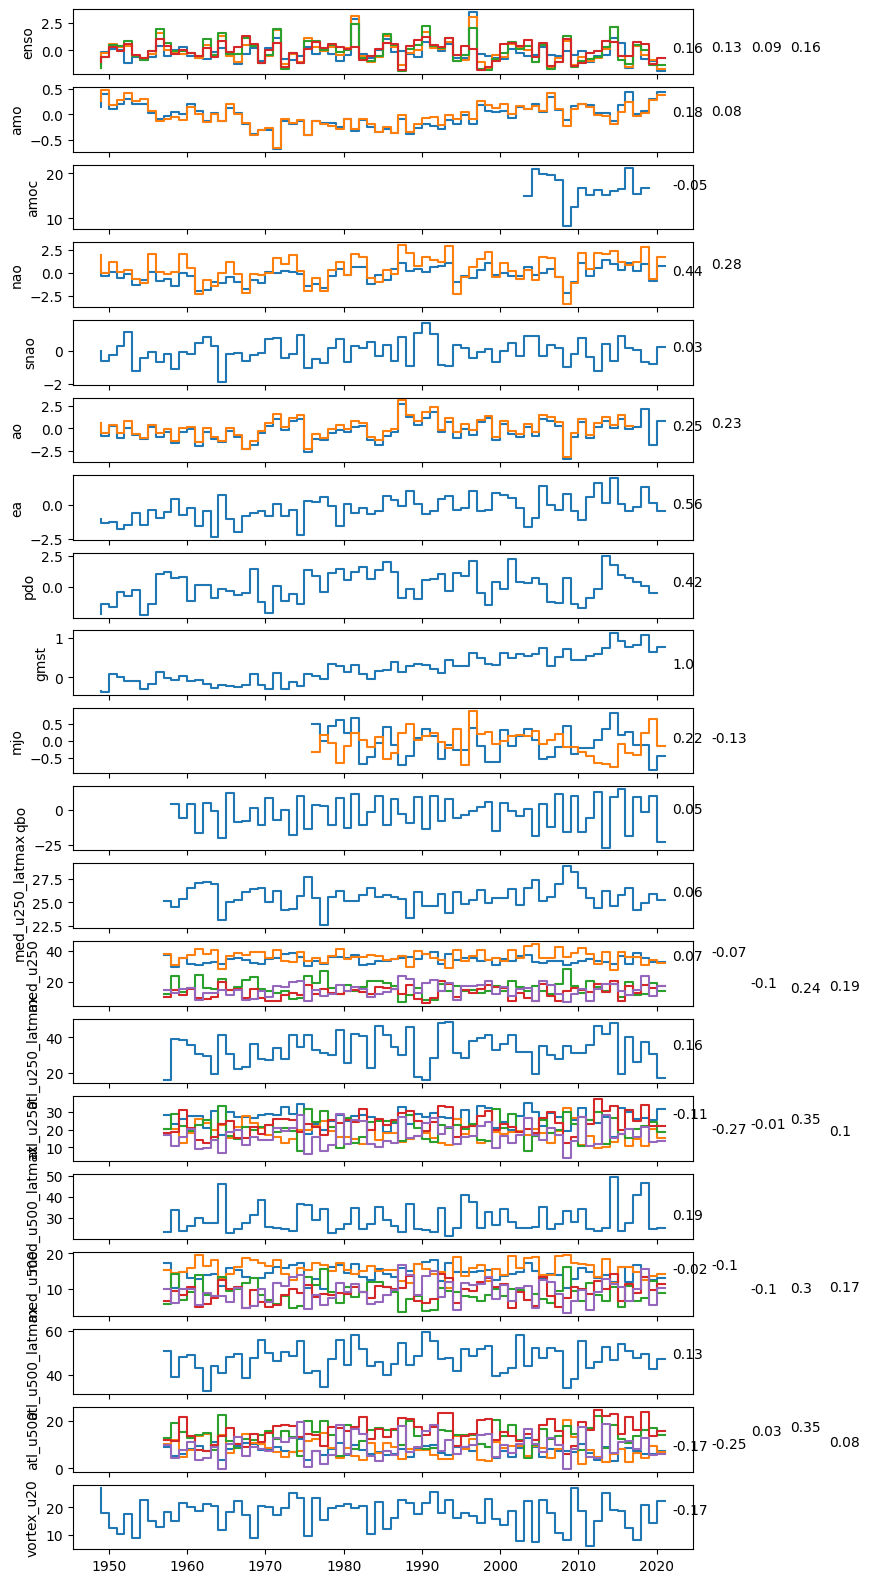

In [161]:
gmst = test['gmst'].squeeze()
names = test.columns.get_level_values('name').unique()
fig, axes = plt.subplots(nrows = len(names), sharex = True, figsize = (8,20))
for i, name in enumerate(names):
    ax = axes[i]
    dat = test.loc[:,name]
    for j,col in enumerate(dat.columns):
        series = dat[col]
        corr = pearsonr(gmst.loc[~series.isnull()],series.loc[~series.isnull()])
        ax.text(2022+5*j,series.mean(), s = np.round(corr[0],2))
        ax.step(test.index, series, label = col)
    ax.set_ylabel(name)

East Atlantic pattern pretty trended. Strong correlation with GMST
Also the blue NAO index is quite trended.

#### Correlation Matrices at multiple timescales.

In [229]:
def simultaneous_resample(firstmonth = 12, lastmonth = 1, average = True):
    """
    lastmonth is inclusive
    """
    combined = df.join(target)
    if firstmonth > lastmonth:
        months = np.arange(firstmonth - 12, lastmonth + 1, 1)
        months  = np.where(months <=0, months + 12, months)
    else:
        months = np.arange(firstmonth, lastmonth + 1, 1)
    if average:
        cal = lilio.Calendar(anchor = f'{firstmonth}-01')
        cal.add_intervals("precursor", length=f"{len(months)}M", n=1, gap = f'-{len(months)}M') # Fully co-occurring
    else:
        cal = lilio.Calendar(anchor = f'{lastmonth}-01')
        cal.add_intervals("precursor", length="1M", n=1, gap = '-1M') # Fully co-occurring
        if len(months) > 1:
            cal.add_intervals("precursor", length="1M", n=len(months)-1, gap = '0M') # Fully co-occurring
    cal.map_years(start=1949, end=2023)
    res = lilio.resample(cal, combined, how = 'nanmean')
    res = res.set_index(['anchor_year','i_interval','interval']).drop('is_target', axis = 1) # Lilio bookkeeping
    res.columns = pd.MultiIndex.from_tuples(res.columns, names = df.columns.names)
    return res

def lagged_resample(separation = 0, firstmonth = 12, lastmonth = 12, n = 1, precursor_agg = 1, allow_precursor_overlap = False):
    """
    Separation between target and first precursor is in terms of number of months.
    Always an averaging is applied.
    Averaging period for target is determined by firstmonth / lastmonth interval (lastmonth is inclusive)
    Averaging period for precursor is given as integer in number of months
    if precursor_agg > 1, you can opt for allowing overlap. 
    """
    combined = df.join(target)
    if firstmonth > lastmonth:
        months = np.arange(firstmonth - 12, lastmonth + 1, 1)
        months  = np.where(months <=0, months + 12, months)
    else:
        months = np.arange(firstmonth, lastmonth + 1, 1)
    cal = lilio.Calendar(anchor = f'{firstmonth}-01')
    cal.add_intervals("target", length=f"{len(months)}M")
    counter = n
    while counter > 0:
        if counter == n: # First precursor
            gap = separation
        elif (precursor_agg > 1) and allow_precursor_overlap:
            gap = -(precursor_agg - 1)
        else:
            gap = 0
        cal.add_intervals("precursor", length=f"{precursor_agg}M", n=1, gap = f'{gap}M')
        counter -= 1
    cal.map_years(start=1949, end=2023)
    res = lilio.resample(cal, combined, how = 'nanmean')
    res = res.set_index(['anchor_year','i_interval']).drop('interval', axis = 1)
    y = res.loc[res['is_target'],[('rrmon',0,'EOBS')]].unstack('i_interval')
    X = res.loc[~res['is_target'],:].drop([('rrmon',0,'EOBS'),'is_target'], axis = 1).unstack('i_interval')
    X.columns.names = ['variables','i_interval']
    #X.columns = pd.MultiIndex.from_tuples(X.columns) # Should be done before unstacking
    return X, y, cal # Also return the calendar for bookkeeping.

In [67]:
exampledf = simultaneous_resample(firstmonth = 1, lastmonth = 1, average = False)
# Plotting correlations per month, single months
#corwith = ('gmst',0,'hadcrut5')
corwith = ('rrmon',0,'EOBS')
othervars = exampledf.columns.drop(corwith)
months = [10,11,12,1,2,3,4,5]
corrcoefs = xr.DataArray(np.full((len(months),len(othervars)),np.nan), dims = ('month','variables'),
                        coords = {'month':months, 'variables':othervars}, name = 'spearmanr')
for month in months:
    monthly = simultaneous_resample(firstmonth = month, lastmonth = month, average = False)
    for var in othervars:
        dat = monthly.loc[:,[var,corwith]].dropna(how = 'any')
        corrcoefs.loc[month,var] = spearmanr(dat)[0]

/scistor/ivm/jsn295/NEWJUPVENV/lib/python3.10/site-packages/lilio/resampling.py:165: RuntimeWarning: Mean of empty slice
  resampled_data[i] = resampling_method(input_data[colname].values[row])
/scistor/ivm/jsn295/NEWJUPVENV/lib/python3.10/site-packages/lilio/resampling.py:165: RuntimeWarning: Mean of empty slice
  resampled_data[i] = resampling_method(input_data[colname].values[row])
/scistor/ivm/jsn295/NEWJUPVENV/lib/python3.10/site-packages/lilio/resampling.py:165: RuntimeWarning: Mean of empty slice
  resampled_data[i] = resampling_method(input_data[colname].values[row])
/scistor/ivm/jsn295/NEWJUPVENV/lib/python3.10/site-packages/lilio/resampling.py:165: RuntimeWarning: Mean of empty slice
  resampled_data[i] = resampling_method(input_data[colname].values[row])
/scistor/ivm/jsn295/NEWJUPVENV/lib/python3.10/site-packages/lilio/resampling.py:165: RuntimeWarning: Mean of empty slice
  resampled_data[i] = resampling_method(input_data[colname].values[row])
/scistor/ivm/jsn295/NEWJUPVENV

/scistor/ivm/jsn295/NEWJUPVENV/lib/python3.10/site-packages/lilio/resampling.py:165: RuntimeWarning: Mean of empty slice
  resampled_data[i] = resampling_method(input_data[colname].values[row])
/scistor/ivm/jsn295/NEWJUPVENV/lib/python3.10/site-packages/lilio/resampling.py:165: RuntimeWarning: Mean of empty slice
  resampled_data[i] = resampling_method(input_data[colname].values[row])
/scistor/ivm/jsn295/NEWJUPVENV/lib/python3.10/site-packages/lilio/resampling.py:165: RuntimeWarning: Mean of empty slice
  resampled_data[i] = resampling_method(input_data[colname].values[row])
/scistor/ivm/jsn295/NEWJUPVENV/lib/python3.10/site-packages/lilio/resampling.py:165: RuntimeWarning: Mean of empty slice
  resampled_data[i] = resampling_method(input_data[colname].values[row])
/scistor/ivm/jsn295/NEWJUPVENV/lib/python3.10/site-packages/lilio/resampling.py:165: RuntimeWarning: Mean of empty slice
  resampled_data[i] = resampling_method(input_data[colname].values[row])
/scistor/ivm/jsn295/NEWJUPVENV

/scistor/ivm/jsn295/NEWJUPVENV/lib/python3.10/site-packages/lilio/utils.py:79: UserWarning: The input data could not fully cover the calendar's intervals. Intervals without available data will contain NaN values.
  warnings.warn(
/scistor/ivm/jsn295/NEWJUPVENV/lib/python3.10/site-packages/lilio/resampling.py:165: RuntimeWarning: Mean of empty slice
  resampled_data[i] = resampling_method(input_data[colname].values[row])
/scistor/ivm/jsn295/NEWJUPVENV/lib/python3.10/site-packages/lilio/resampling.py:165: RuntimeWarning: Mean of empty slice
  resampled_data[i] = resampling_method(input_data[colname].values[row])
/scistor/ivm/jsn295/NEWJUPVENV/lib/python3.10/site-packages/lilio/resampling.py:165: RuntimeWarning: Mean of empty slice
  resampled_data[i] = resampling_method(input_data[colname].values[row])
/scistor/ivm/jsn295/NEWJUPVENV/lib/python3.10/site-packages/lilio/resampling.py:165: RuntimeWarning: Mean of empty slice
  resampled_data[i] = resampling_method(input_data[colname].values[

/scistor/ivm/jsn295/NEWJUPVENV/lib/python3.10/site-packages/lilio/resampling.py:165: RuntimeWarning: Mean of empty slice
  resampled_data[i] = resampling_method(input_data[colname].values[row])
/scistor/ivm/jsn295/NEWJUPVENV/lib/python3.10/site-packages/lilio/utils.py:79: UserWarning: The input data could not fully cover the calendar's intervals. Intervals without available data will contain NaN values.
  warnings.warn(
/scistor/ivm/jsn295/NEWJUPVENV/lib/python3.10/site-packages/lilio/resampling.py:165: RuntimeWarning: Mean of empty slice
  resampled_data[i] = resampling_method(input_data[colname].values[row])
/scistor/ivm/jsn295/NEWJUPVENV/lib/python3.10/site-packages/lilio/resampling.py:165: RuntimeWarning: Mean of empty slice
  resampled_data[i] = resampling_method(input_data[colname].values[row])
/scistor/ivm/jsn295/NEWJUPVENV/lib/python3.10/site-packages/lilio/resampling.py:165: RuntimeWarning: Mean of empty slice
  resampled_data[i] = resampling_method(input_data[colname].values[

/scistor/ivm/jsn295/NEWJUPVENV/lib/python3.10/site-packages/lilio/resampling.py:165: RuntimeWarning: Mean of empty slice
  resampled_data[i] = resampling_method(input_data[colname].values[row])
/scistor/ivm/jsn295/NEWJUPVENV/lib/python3.10/site-packages/lilio/resampling.py:165: RuntimeWarning: Mean of empty slice
  resampled_data[i] = resampling_method(input_data[colname].values[row])
/scistor/ivm/jsn295/NEWJUPVENV/lib/python3.10/site-packages/lilio/resampling.py:165: RuntimeWarning: Mean of empty slice
  resampled_data[i] = resampling_method(input_data[colname].values[row])
/scistor/ivm/jsn295/NEWJUPVENV/lib/python3.10/site-packages/lilio/resampling.py:165: RuntimeWarning: Mean of empty slice
  resampled_data[i] = resampling_method(input_data[colname].values[row])
/scistor/ivm/jsn295/NEWJUPVENV/lib/python3.10/site-packages/lilio/resampling.py:165: RuntimeWarning: Mean of empty slice
  resampled_data[i] = resampling_method(input_data[colname].values[row])
/scistor/ivm/jsn295/NEWJUPVENV

/scistor/ivm/jsn295/NEWJUPVENV/lib/python3.10/site-packages/lilio/resampling.py:165: RuntimeWarning: Mean of empty slice
  resampled_data[i] = resampling_method(input_data[colname].values[row])
/scistor/ivm/jsn295/NEWJUPVENV/lib/python3.10/site-packages/lilio/resampling.py:165: RuntimeWarning: Mean of empty slice
  resampled_data[i] = resampling_method(input_data[colname].values[row])
/scistor/ivm/jsn295/NEWJUPVENV/lib/python3.10/site-packages/lilio/resampling.py:165: RuntimeWarning: Mean of empty slice
  resampled_data[i] = resampling_method(input_data[colname].values[row])
/scistor/ivm/jsn295/NEWJUPVENV/lib/python3.10/site-packages/lilio/resampling.py:165: RuntimeWarning: Mean of empty slice
  resampled_data[i] = resampling_method(input_data[colname].values[row])
/scistor/ivm/jsn295/NEWJUPVENV/lib/python3.10/site-packages/lilio/resampling.py:165: RuntimeWarning: Mean of empty slice
  resampled_data[i] = resampling_method(input_data[colname].values[row])
/scistor/ivm/jsn295/NEWJUPVENV

/scistor/ivm/jsn295/NEWJUPVENV/lib/python3.10/site-packages/lilio/resampling.py:165: RuntimeWarning: Mean of empty slice
  resampled_data[i] = resampling_method(input_data[colname].values[row])
/scistor/ivm/jsn295/NEWJUPVENV/lib/python3.10/site-packages/lilio/resampling.py:165: RuntimeWarning: Mean of empty slice
  resampled_data[i] = resampling_method(input_data[colname].values[row])
/scistor/ivm/jsn295/NEWJUPVENV/lib/python3.10/site-packages/lilio/resampling.py:165: RuntimeWarning: Mean of empty slice
  resampled_data[i] = resampling_method(input_data[colname].values[row])
/scistor/ivm/jsn295/NEWJUPVENV/lib/python3.10/site-packages/lilio/resampling.py:165: RuntimeWarning: Mean of empty slice
  resampled_data[i] = resampling_method(input_data[colname].values[row])
/scistor/ivm/jsn295/NEWJUPVENV/lib/python3.10/site-packages/lilio/resampling.py:165: RuntimeWarning: Mean of empty slice
  resampled_data[i] = resampling_method(input_data[colname].values[row])
/scistor/ivm/jsn295/NEWJUPVENV

/scistor/ivm/jsn295/NEWJUPVENV/lib/python3.10/site-packages/lilio/resampling.py:165: RuntimeWarning: Mean of empty slice
  resampled_data[i] = resampling_method(input_data[colname].values[row])
/scistor/ivm/jsn295/NEWJUPVENV/lib/python3.10/site-packages/lilio/resampling.py:165: RuntimeWarning: Mean of empty slice
  resampled_data[i] = resampling_method(input_data[colname].values[row])
/scistor/ivm/jsn295/NEWJUPVENV/lib/python3.10/site-packages/lilio/resampling.py:165: RuntimeWarning: Mean of empty slice
  resampled_data[i] = resampling_method(input_data[colname].values[row])
/scistor/ivm/jsn295/NEWJUPVENV/lib/python3.10/site-packages/lilio/resampling.py:165: RuntimeWarning: Mean of empty slice
  resampled_data[i] = resampling_method(input_data[colname].values[row])
/scistor/ivm/jsn295/NEWJUPVENV/lib/python3.10/site-packages/lilio/resampling.py:165: RuntimeWarning: Mean of empty slice
  resampled_data[i] = resampling_method(input_data[colname].values[row])
/scistor/ivm/jsn295/NEWJUPVENV

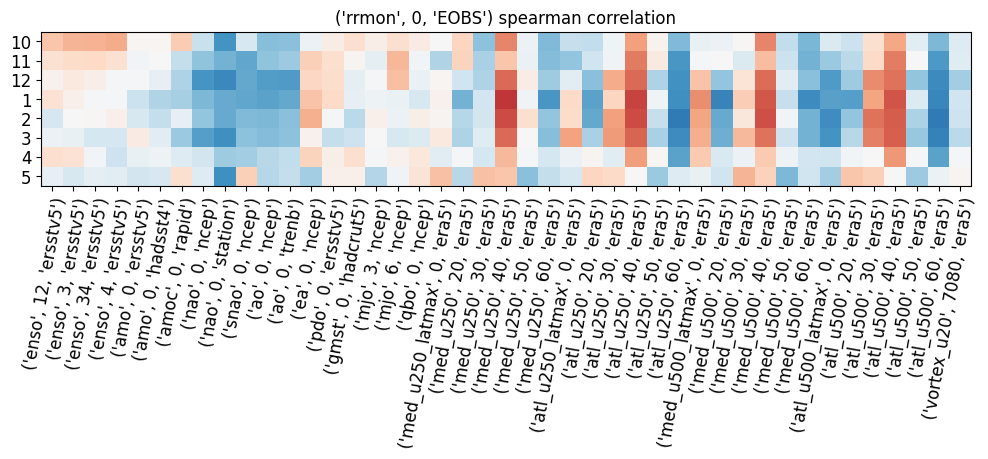

In [68]:
fig, ax = plt.subplots(figsize = (12,2))
im = ax.imshow(corrcoefs.values, vmin = -1, vmax = 1, cmap = 'RdBu_r', aspect = 'auto')

# Show all ticks and label them with the respective list entries
ax.set_xticks(np.arange(corrcoefs.shape[1]))
ax.set_xticklabels(corrcoefs.indexes['variables'].to_flat_index().values, size = 12)
ax.set_yticks(np.arange(corrcoefs.shape[0]))
ax.set_yticklabels(corrcoefs.indexes['month'].values, size = 12)
ax.set_title(f'{corwith} spearman correlation')

plt.setp(ax.get_xticklabels(), rotation=80, ha="right",
         rotation_mode="anchor")
plt.show()

MJO phase 6 is interesting, enso in october. NAO entire winter, station based is better.

In [70]:
# Plotting correlations for multiple months aggregation, starting november
#corwith = ('gmst',0,'hadcrut5')
corwith = ('rrmon',0,'EOBS')
othervars = exampledf.columns.drop(corwith)
startmonth = 11
endmonths = [11,12,1,2,3,4]
corrcoefs = xr.DataArray(np.full((len(months),len(othervars)),np.nan), dims = ('month','variables'),
                        coords = {'month':months, 'variables':othervars}, name = 'spearmanr')
for month in endmonths:
    monthly = simultaneous_resample(firstmonth = startmonth, lastmonth = month, average = True)
    for var in othervars:
        dat = monthly.loc[:,[var,corwith]].dropna(how = 'any')
        corrcoefs.loc[month,var] = spearmanr(dat)[0]

/scistor/ivm/jsn295/NEWJUPVENV/lib/python3.10/site-packages/lilio/resampling.py:165: RuntimeWarning: Mean of empty slice
  resampled_data[i] = resampling_method(input_data[colname].values[row])
/scistor/ivm/jsn295/NEWJUPVENV/lib/python3.10/site-packages/lilio/resampling.py:165: RuntimeWarning: Mean of empty slice
  resampled_data[i] = resampling_method(input_data[colname].values[row])
/scistor/ivm/jsn295/NEWJUPVENV/lib/python3.10/site-packages/lilio/resampling.py:165: RuntimeWarning: Mean of empty slice
  resampled_data[i] = resampling_method(input_data[colname].values[row])
/scistor/ivm/jsn295/NEWJUPVENV/lib/python3.10/site-packages/lilio/resampling.py:165: RuntimeWarning: Mean of empty slice
  resampled_data[i] = resampling_method(input_data[colname].values[row])
/scistor/ivm/jsn295/NEWJUPVENV/lib/python3.10/site-packages/lilio/resampling.py:165: RuntimeWarning: Mean of empty slice
  resampled_data[i] = resampling_method(input_data[colname].values[row])
/scistor/ivm/jsn295/NEWJUPVENV

/scistor/ivm/jsn295/NEWJUPVENV/lib/python3.10/site-packages/lilio/resampling.py:165: RuntimeWarning: Mean of empty slice
  resampled_data[i] = resampling_method(input_data[colname].values[row])
/scistor/ivm/jsn295/NEWJUPVENV/lib/python3.10/site-packages/lilio/resampling.py:165: RuntimeWarning: Mean of empty slice
  resampled_data[i] = resampling_method(input_data[colname].values[row])
/scistor/ivm/jsn295/NEWJUPVENV/lib/python3.10/site-packages/lilio/resampling.py:165: RuntimeWarning: Mean of empty slice
  resampled_data[i] = resampling_method(input_data[colname].values[row])
/scistor/ivm/jsn295/NEWJUPVENV/lib/python3.10/site-packages/lilio/resampling.py:165: RuntimeWarning: Mean of empty slice
  resampled_data[i] = resampling_method(input_data[colname].values[row])
/scistor/ivm/jsn295/NEWJUPVENV/lib/python3.10/site-packages/lilio/resampling.py:165: RuntimeWarning: Mean of empty slice
  resampled_data[i] = resampling_method(input_data[colname].values[row])
/scistor/ivm/jsn295/NEWJUPVENV

/scistor/ivm/jsn295/NEWJUPVENV/lib/python3.10/site-packages/lilio/resampling.py:165: RuntimeWarning: Mean of empty slice
  resampled_data[i] = resampling_method(input_data[colname].values[row])
/scistor/ivm/jsn295/NEWJUPVENV/lib/python3.10/site-packages/lilio/resampling.py:165: RuntimeWarning: Mean of empty slice
  resampled_data[i] = resampling_method(input_data[colname].values[row])
/scistor/ivm/jsn295/NEWJUPVENV/lib/python3.10/site-packages/lilio/resampling.py:165: RuntimeWarning: Mean of empty slice
  resampled_data[i] = resampling_method(input_data[colname].values[row])
/scistor/ivm/jsn295/NEWJUPVENV/lib/python3.10/site-packages/lilio/resampling.py:165: RuntimeWarning: Mean of empty slice
  resampled_data[i] = resampling_method(input_data[colname].values[row])
/scistor/ivm/jsn295/NEWJUPVENV/lib/python3.10/site-packages/lilio/resampling.py:165: RuntimeWarning: Mean of empty slice
  resampled_data[i] = resampling_method(input_data[colname].values[row])
/scistor/ivm/jsn295/NEWJUPVENV

/scistor/ivm/jsn295/NEWJUPVENV/lib/python3.10/site-packages/lilio/resampling.py:165: RuntimeWarning: Mean of empty slice
  resampled_data[i] = resampling_method(input_data[colname].values[row])
/scistor/ivm/jsn295/NEWJUPVENV/lib/python3.10/site-packages/lilio/resampling.py:165: RuntimeWarning: Mean of empty slice
  resampled_data[i] = resampling_method(input_data[colname].values[row])
/scistor/ivm/jsn295/NEWJUPVENV/lib/python3.10/site-packages/lilio/resampling.py:165: RuntimeWarning: Mean of empty slice
  resampled_data[i] = resampling_method(input_data[colname].values[row])
/scistor/ivm/jsn295/NEWJUPVENV/lib/python3.10/site-packages/lilio/resampling.py:165: RuntimeWarning: Mean of empty slice
  resampled_data[i] = resampling_method(input_data[colname].values[row])
/scistor/ivm/jsn295/NEWJUPVENV/lib/python3.10/site-packages/lilio/resampling.py:165: RuntimeWarning: Mean of empty slice
  resampled_data[i] = resampling_method(input_data[colname].values[row])
/scistor/ivm/jsn295/NEWJUPVENV

/scistor/ivm/jsn295/NEWJUPVENV/lib/python3.10/site-packages/lilio/resampling.py:165: RuntimeWarning: Mean of empty slice
  resampled_data[i] = resampling_method(input_data[colname].values[row])
/scistor/ivm/jsn295/NEWJUPVENV/lib/python3.10/site-packages/lilio/resampling.py:165: RuntimeWarning: Mean of empty slice
  resampled_data[i] = resampling_method(input_data[colname].values[row])
/scistor/ivm/jsn295/NEWJUPVENV/lib/python3.10/site-packages/lilio/resampling.py:165: RuntimeWarning: Mean of empty slice
  resampled_data[i] = resampling_method(input_data[colname].values[row])
/scistor/ivm/jsn295/NEWJUPVENV/lib/python3.10/site-packages/lilio/resampling.py:165: RuntimeWarning: Mean of empty slice
  resampled_data[i] = resampling_method(input_data[colname].values[row])
/scistor/ivm/jsn295/NEWJUPVENV/lib/python3.10/site-packages/lilio/resampling.py:165: RuntimeWarning: Mean of empty slice
  resampled_data[i] = resampling_method(input_data[colname].values[row])
/scistor/ivm/jsn295/NEWJUPVENV

/scistor/ivm/jsn295/NEWJUPVENV/lib/python3.10/site-packages/lilio/resampling.py:165: RuntimeWarning: Mean of empty slice
  resampled_data[i] = resampling_method(input_data[colname].values[row])
/scistor/ivm/jsn295/NEWJUPVENV/lib/python3.10/site-packages/lilio/resampling.py:165: RuntimeWarning: Mean of empty slice
  resampled_data[i] = resampling_method(input_data[colname].values[row])
/scistor/ivm/jsn295/NEWJUPVENV/lib/python3.10/site-packages/lilio/resampling.py:165: RuntimeWarning: Mean of empty slice
  resampled_data[i] = resampling_method(input_data[colname].values[row])
/scistor/ivm/jsn295/NEWJUPVENV/lib/python3.10/site-packages/lilio/resampling.py:165: RuntimeWarning: Mean of empty slice
  resampled_data[i] = resampling_method(input_data[colname].values[row])
/scistor/ivm/jsn295/NEWJUPVENV/lib/python3.10/site-packages/lilio/resampling.py:165: RuntimeWarning: Mean of empty slice
  resampled_data[i] = resampling_method(input_data[colname].values[row])
/scistor/ivm/jsn295/NEWJUPVENV

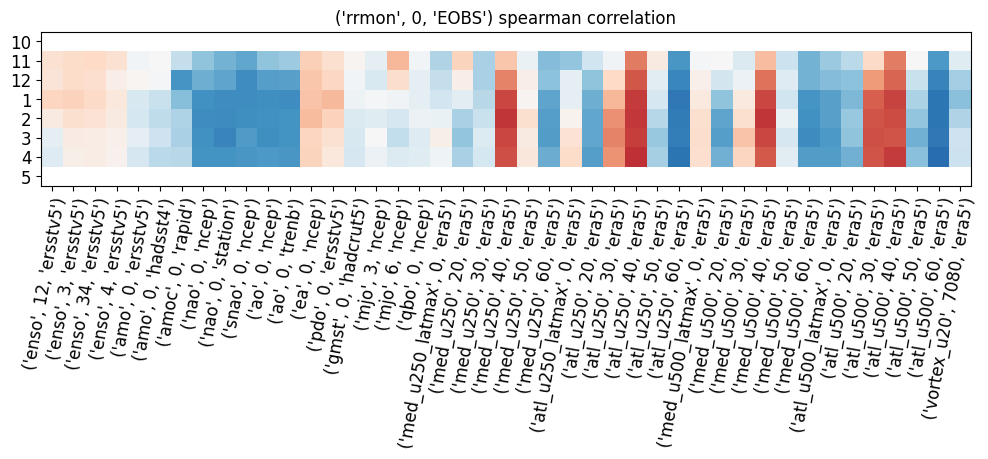

In [71]:
fig, ax = plt.subplots(figsize = (12,2))
im = ax.imshow(corrcoefs.values, vmin = -1, vmax = 1, cmap = 'RdBu_r', aspect = 'auto')

# Show all ticks and label them with the respective list entries
ax.set_xticks(np.arange(corrcoefs.shape[1]))
ax.set_xticklabels(corrcoefs.indexes['variables'].to_flat_index().values, size = 12)
ax.set_yticks(np.arange(corrcoefs.shape[0]))
ax.set_yticklabels(corrcoefs.indexes['month'].values, size = 12)
ax.set_title(f'{corwith} spearman correlation')

plt.setp(ax.get_xticklabels(), rotation=80, ha="right",
         rotation_mode="anchor")
plt.show()

### Simultaneous univariate association
Functions of sklearn (mutual_info_regression, f_regression) could be called by themselves in this univariate setting. Does in principle not need wrapping in SelectKBest

In [73]:
from sklearn.feature_selection import mutual_info_regression, f_regression

In [54]:
dropped = df.drop('amoc', axis = 1).dropna()
target_dropped = target.loc[dropped.index,:].squeeze()

/tmp/ipykernel_144045/1718627699.py:1: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  dropped = df.drop('amoc', axis = 1).dropna()


In [95]:
exampledf = simultaneous_resample(firstmonth = 1, lastmonth = 1, average = False)
# Plotting correlations per month, single months
#corwith = ('gmst',0,'hadcrut5')
corwith = ('rrmon',0,'EOBS')
othervars = exampledf.columns.drop(corwith)
months = [10,11,12,1,2,3,4,5]
coefs = xr.DataArray(np.full((len(months),len(othervars)),np.nan), dims = ('month','variables'),
                        coords = {'month':months, 'variables':othervars}, name = 'f_stat')
pvals = xr.DataArray(np.full((len(months),len(othervars)),np.nan), dims = ('month','variables'),
                        coords = {'month':months, 'variables':othervars}, name = 'p_val')
for month in months:
    monthly = simultaneous_resample(firstmonth = month, lastmonth = month, average = False)
    for var in othervars: 
        dat = monthly.loc[:,[var,corwith]].dropna(how = 'any') # Per var, because otherwise all are limited by shortest length
        coefs.loc[[month],var], pvals.loc[[month],var] = f_regression(X = dat[[var]], y = dat[corwith])
        #coefs.loc[[month],var] = mutual_info_regression(X = dat[[var]], y = dat[corwith])
#selector = SelectKBest(score_func = , k = 3)
#selector.fit(X = dropped, y = target_dropped)
#selector.scores_


/scistor/ivm/jsn295/NEWJUPVENV/lib/python3.10/site-packages/lilio/resampling.py:165: RuntimeWarning: Mean of empty slice
  resampled_data[i] = resampling_method(input_data[colname].values[row])
/scistor/ivm/jsn295/NEWJUPVENV/lib/python3.10/site-packages/lilio/resampling.py:165: RuntimeWarning: Mean of empty slice
  resampled_data[i] = resampling_method(input_data[colname].values[row])
/scistor/ivm/jsn295/NEWJUPVENV/lib/python3.10/site-packages/lilio/resampling.py:165: RuntimeWarning: Mean of empty slice
  resampled_data[i] = resampling_method(input_data[colname].values[row])
/scistor/ivm/jsn295/NEWJUPVENV/lib/python3.10/site-packages/lilio/resampling.py:165: RuntimeWarning: Mean of empty slice
  resampled_data[i] = resampling_method(input_data[colname].values[row])
/scistor/ivm/jsn295/NEWJUPVENV/lib/python3.10/site-packages/lilio/resampling.py:165: RuntimeWarning: Mean of empty slice
  resampled_data[i] = resampling_method(input_data[colname].values[row])
/scistor/ivm/jsn295/NEWJUPVENV

/scistor/ivm/jsn295/NEWJUPVENV/lib/python3.10/site-packages/lilio/resampling.py:165: RuntimeWarning: Mean of empty slice
  resampled_data[i] = resampling_method(input_data[colname].values[row])
/scistor/ivm/jsn295/NEWJUPVENV/lib/python3.10/site-packages/lilio/resampling.py:165: RuntimeWarning: Mean of empty slice
  resampled_data[i] = resampling_method(input_data[colname].values[row])
/scistor/ivm/jsn295/NEWJUPVENV/lib/python3.10/site-packages/lilio/resampling.py:165: RuntimeWarning: Mean of empty slice
  resampled_data[i] = resampling_method(input_data[colname].values[row])
/scistor/ivm/jsn295/NEWJUPVENV/lib/python3.10/site-packages/lilio/resampling.py:165: RuntimeWarning: Mean of empty slice
  resampled_data[i] = resampling_method(input_data[colname].values[row])
/scistor/ivm/jsn295/NEWJUPVENV/lib/python3.10/site-packages/lilio/resampling.py:165: RuntimeWarning: Mean of empty slice
  resampled_data[i] = resampling_method(input_data[colname].values[row])
/scistor/ivm/jsn295/NEWJUPVENV

/scistor/ivm/jsn295/NEWJUPVENV/lib/python3.10/site-packages/lilio/resampling.py:165: RuntimeWarning: Mean of empty slice
  resampled_data[i] = resampling_method(input_data[colname].values[row])
/scistor/ivm/jsn295/NEWJUPVENV/lib/python3.10/site-packages/lilio/resampling.py:165: RuntimeWarning: Mean of empty slice
  resampled_data[i] = resampling_method(input_data[colname].values[row])
/scistor/ivm/jsn295/NEWJUPVENV/lib/python3.10/site-packages/lilio/resampling.py:165: RuntimeWarning: Mean of empty slice
  resampled_data[i] = resampling_method(input_data[colname].values[row])
/scistor/ivm/jsn295/NEWJUPVENV/lib/python3.10/site-packages/lilio/resampling.py:165: RuntimeWarning: Mean of empty slice
  resampled_data[i] = resampling_method(input_data[colname].values[row])
/scistor/ivm/jsn295/NEWJUPVENV/lib/python3.10/site-packages/lilio/resampling.py:165: RuntimeWarning: Mean of empty slice
  resampled_data[i] = resampling_method(input_data[colname].values[row])
/scistor/ivm/jsn295/NEWJUPVENV

/scistor/ivm/jsn295/NEWJUPVENV/lib/python3.10/site-packages/lilio/resampling.py:165: RuntimeWarning: Mean of empty slice
  resampled_data[i] = resampling_method(input_data[colname].values[row])
/scistor/ivm/jsn295/NEWJUPVENV/lib/python3.10/site-packages/lilio/resampling.py:165: RuntimeWarning: Mean of empty slice
  resampled_data[i] = resampling_method(input_data[colname].values[row])
/scistor/ivm/jsn295/NEWJUPVENV/lib/python3.10/site-packages/lilio/resampling.py:165: RuntimeWarning: Mean of empty slice
  resampled_data[i] = resampling_method(input_data[colname].values[row])
/scistor/ivm/jsn295/NEWJUPVENV/lib/python3.10/site-packages/lilio/resampling.py:165: RuntimeWarning: Mean of empty slice
  resampled_data[i] = resampling_method(input_data[colname].values[row])
/scistor/ivm/jsn295/NEWJUPVENV/lib/python3.10/site-packages/lilio/resampling.py:165: RuntimeWarning: Mean of empty slice
  resampled_data[i] = resampling_method(input_data[colname].values[row])
/scistor/ivm/jsn295/NEWJUPVENV

/scistor/ivm/jsn295/NEWJUPVENV/lib/python3.10/site-packages/lilio/resampling.py:165: RuntimeWarning: Mean of empty slice
  resampled_data[i] = resampling_method(input_data[colname].values[row])
/scistor/ivm/jsn295/NEWJUPVENV/lib/python3.10/site-packages/lilio/resampling.py:165: RuntimeWarning: Mean of empty slice
  resampled_data[i] = resampling_method(input_data[colname].values[row])
/scistor/ivm/jsn295/NEWJUPVENV/lib/python3.10/site-packages/lilio/resampling.py:165: RuntimeWarning: Mean of empty slice
  resampled_data[i] = resampling_method(input_data[colname].values[row])
/scistor/ivm/jsn295/NEWJUPVENV/lib/python3.10/site-packages/lilio/resampling.py:165: RuntimeWarning: Mean of empty slice
  resampled_data[i] = resampling_method(input_data[colname].values[row])
/scistor/ivm/jsn295/NEWJUPVENV/lib/python3.10/site-packages/lilio/resampling.py:165: RuntimeWarning: Mean of empty slice
  resampled_data[i] = resampling_method(input_data[colname].values[row])
/scistor/ivm/jsn295/NEWJUPVENV

/scistor/ivm/jsn295/NEWJUPVENV/lib/python3.10/site-packages/lilio/resampling.py:165: RuntimeWarning: Mean of empty slice
  resampled_data[i] = resampling_method(input_data[colname].values[row])
/scistor/ivm/jsn295/NEWJUPVENV/lib/python3.10/site-packages/lilio/resampling.py:165: RuntimeWarning: Mean of empty slice
  resampled_data[i] = resampling_method(input_data[colname].values[row])
/scistor/ivm/jsn295/NEWJUPVENV/lib/python3.10/site-packages/lilio/resampling.py:165: RuntimeWarning: Mean of empty slice
  resampled_data[i] = resampling_method(input_data[colname].values[row])
/scistor/ivm/jsn295/NEWJUPVENV/lib/python3.10/site-packages/lilio/resampling.py:165: RuntimeWarning: Mean of empty slice
  resampled_data[i] = resampling_method(input_data[colname].values[row])
/scistor/ivm/jsn295/NEWJUPVENV/lib/python3.10/site-packages/lilio/resampling.py:165: RuntimeWarning: Mean of empty slice
  resampled_data[i] = resampling_method(input_data[colname].values[row])
/scistor/ivm/jsn295/NEWJUPVENV

/scistor/ivm/jsn295/NEWJUPVENV/lib/python3.10/site-packages/lilio/resampling.py:165: RuntimeWarning: Mean of empty slice
  resampled_data[i] = resampling_method(input_data[colname].values[row])
/scistor/ivm/jsn295/NEWJUPVENV/lib/python3.10/site-packages/lilio/resampling.py:165: RuntimeWarning: Mean of empty slice
  resampled_data[i] = resampling_method(input_data[colname].values[row])
/scistor/ivm/jsn295/NEWJUPVENV/lib/python3.10/site-packages/lilio/resampling.py:165: RuntimeWarning: Mean of empty slice
  resampled_data[i] = resampling_method(input_data[colname].values[row])
/scistor/ivm/jsn295/NEWJUPVENV/lib/python3.10/site-packages/lilio/resampling.py:165: RuntimeWarning: Mean of empty slice
  resampled_data[i] = resampling_method(input_data[colname].values[row])
/scistor/ivm/jsn295/NEWJUPVENV/lib/python3.10/site-packages/lilio/resampling.py:165: RuntimeWarning: Mean of empty slice
  resampled_data[i] = resampling_method(input_data[colname].values[row])
/scistor/ivm/jsn295/NEWJUPVENV

/scistor/ivm/jsn295/NEWJUPVENV/lib/python3.10/site-packages/lilio/resampling.py:165: RuntimeWarning: Mean of empty slice
  resampled_data[i] = resampling_method(input_data[colname].values[row])
/scistor/ivm/jsn295/NEWJUPVENV/lib/python3.10/site-packages/lilio/resampling.py:165: RuntimeWarning: Mean of empty slice
  resampled_data[i] = resampling_method(input_data[colname].values[row])
/scistor/ivm/jsn295/NEWJUPVENV/lib/python3.10/site-packages/lilio/resampling.py:165: RuntimeWarning: Mean of empty slice
  resampled_data[i] = resampling_method(input_data[colname].values[row])
/scistor/ivm/jsn295/NEWJUPVENV/lib/python3.10/site-packages/lilio/resampling.py:165: RuntimeWarning: Mean of empty slice
  resampled_data[i] = resampling_method(input_data[colname].values[row])
/scistor/ivm/jsn295/NEWJUPVENV/lib/python3.10/site-packages/lilio/resampling.py:165: RuntimeWarning: Mean of empty slice
  resampled_data[i] = resampling_method(input_data[colname].values[row])
/scistor/ivm/jsn295/NEWJUPVENV

/scistor/ivm/jsn295/NEWJUPVENV/lib/python3.10/site-packages/lilio/resampling.py:165: RuntimeWarning: Mean of empty slice
  resampled_data[i] = resampling_method(input_data[colname].values[row])
/scistor/ivm/jsn295/NEWJUPVENV/lib/python3.10/site-packages/lilio/resampling.py:165: RuntimeWarning: Mean of empty slice
  resampled_data[i] = resampling_method(input_data[colname].values[row])
/scistor/ivm/jsn295/NEWJUPVENV/lib/python3.10/site-packages/lilio/resampling.py:165: RuntimeWarning: Mean of empty slice
  resampled_data[i] = resampling_method(input_data[colname].values[row])
/scistor/ivm/jsn295/NEWJUPVENV/lib/python3.10/site-packages/lilio/resampling.py:165: RuntimeWarning: Mean of empty slice
  resampled_data[i] = resampling_method(input_data[colname].values[row])
/scistor/ivm/jsn295/NEWJUPVENV/lib/python3.10/site-packages/lilio/resampling.py:165: RuntimeWarning: Mean of empty slice
  resampled_data[i] = resampling_method(input_data[colname].values[row])
/scistor/ivm/jsn295/NEWJUPVENV

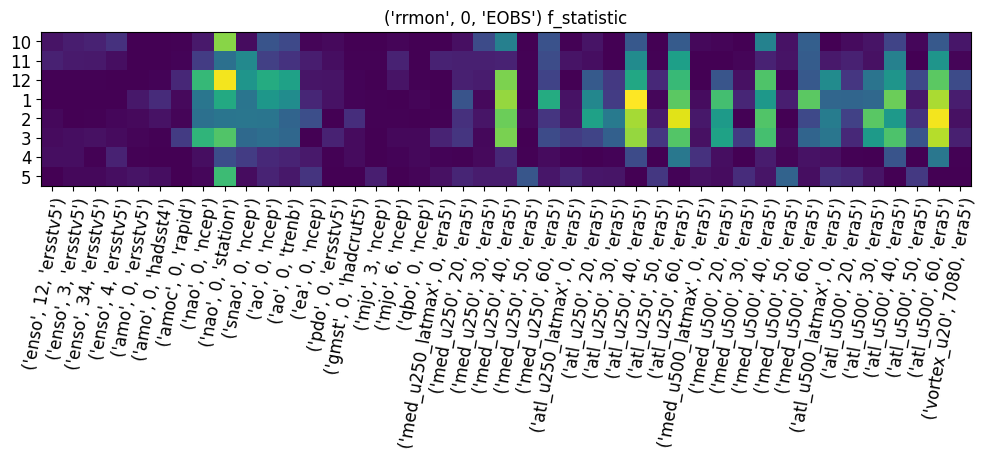

In [96]:
fig, ax = plt.subplots(figsize = (12,2))
im = ax.imshow(coefs.values, aspect = 'auto')

# Show all ticks and label them with the respective list entries
ax.set_xticks(np.arange(coefs.shape[1]))
ax.set_xticklabels(coefs.indexes['variables'].to_flat_index().values, size = 12)
ax.set_yticks(np.arange(coefs.shape[0]))
ax.set_yticklabels(coefs.indexes['month'].values, size = 12)
ax.set_title(f'{corwith} f_statistic')

plt.setp(ax.get_xticklabels(), rotation=80, ha="right",
         rotation_mode="anchor")
plt.show()

### Lagged univariate association

/scistor/ivm/jsn295/NEWJUPVENV/lib/python3.10/site-packages/lilio/utils.py:79: UserWarning: The input data could not fully cover the calendar's intervals. Intervals without available data will contain NaN values.
  warnings.warn(


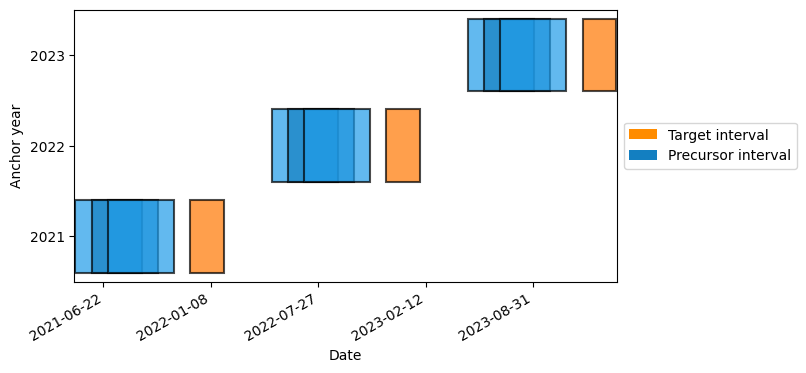

In [205]:
# Showcase
X, y, cal = lagged_resample(lastmonth = 1, separation = 1, n = 3, precursor_agg = 4, allow_precursor_overlap=True)
cal.visualize()

In [239]:
X, y, cal = lagged_resample(firstmonth=12, lastmonth = 3, separation = 0, n = 3, precursor_agg = 4, allow_precursor_overlap=True)
variables = X.columns.get_level_values(0).unique().values
#shifts = X.columns.get_level_values(-1).unique().values
coefs = xr.DataArray(np.full((X.shape[-1],),np.nan), dims = ('stacked_index',),
                        coords = {'stacked_index':X.columns}, name = 'correlation')
for var in variables: 
    X_subset = X.loc[:,(var, slice(None))].dropna(how = 'any') # Per var, because otherwise all are limited by shortest length
    #coefs.loc[[month],var], pvals.loc[[month],var] = f_regression(X = dat[[var]], y = dat[corwith])

/scistor/ivm/jsn295/NEWJUPVENV/lib/python3.10/site-packages/lilio/utils.py:79: UserWarning: The input data could not fully cover the calendar's intervals. Intervals without available data will contain NaN values.
  warnings.warn(


In [240]:
X_subset

variables   (vortex_u20, 7080, era5)                     
i_interval                        -3        -2         -1
anchor_year                                              
1950                       -2.438240  1.589426   6.777181
1951                       -0.598245  4.420858   9.310684
1952                       -0.439965  3.343086   3.186818
1953                        0.184341  5.784935  11.852350
1954                       -0.668077  3.747176   8.843019
...                              ...       ...        ...
2017                       -1.040026  3.242165   8.446840
2018                       -1.723644  2.774526   8.344432
2019                       -3.278447  1.631540   7.798958
2020                       -1.686159  2.565213   9.424911
2021                       -1.636757  2.294676   8.837761

[72 rows x 3 columns]

In [238]:
X

variables   (enso, 12, ersstv5)                     (enso, 3, ersstv5)  \
i_interval                   -3        -2        -1                 -3   
anchor_year                                                              
1949                        NaN       NaN       NaN                NaN   
1950                  -0.749387 -0.552641 -0.632669          -0.213009   
1951                   1.729350  1.465485  1.148455           0.838400   
1952                  -0.798016 -0.692253 -0.625839          -0.333482   
1953                   0.558203  0.426412  0.389145           0.492790   
...                         ...       ...       ...                ...   
2019                  -1.044669 -1.201057 -1.106447          -0.465412   
2020                  -1.503040 -1.518328 -1.332232          -1.144294   
2021                  -0.646796 -0.849449 -1.135025          -0.611214   
2022                  -1.577140       NaN       NaN          -0.906488   
2023                        NaN       NaN       NaN                NaN   

variables                       (enso, 34, ersstv5)                      \
i_interval         -2        -1                  -3        -2        -1   
anchor_year                                                               
1949              NaN       NaN                 NaN       NaN       NaN   
1950        -0.107458 -0.209828           -0.407162 -0.311574 -0.375983   
1951         0.931382  0.983099            0.716154  0.777025  0.836700   
1952        -0.267287 -0.314598           -0.039245 -0.032421 -0.063394   
1953         0.469077  0.512480            0.662685  0.596859  0.622196   
...               ...       ...                 ...       ...       ...   
2019        -0.482956 -0.393149           -0.046603 -0.041217 -0.015084   
2020        -1.235687 -1.363593           -0.910012 -1.128654 -1.386525   
2021        -0.775598 -0.992834           -0.674620 -0.892088 -1.053059   
2022              NaN       NaN           -0.876785       NaN       NaN   
2023              NaN       NaN                 NaN       NaN       NaN   

variables   (enso, 4, ersstv5)  ... (atl_u500, 40, era5) (atl_u500, 50, era5)  \
i_interval                  -3  ...                   -1                   -3   
anchor_year                     ...                                             
1949                       NaN  ...                  NaN                  NaN   
1950                 -0.533429  ...                  NaN                  NaN   
1951                  0.563603  ...                  NaN                  NaN   
1952                  0.006530  ...                  NaN                  NaN   
1953                  0.368486  ...                  NaN                  NaN   
...                        ...  ...                  ...                  ...   
2019                  0.603074  ...            11.502439            12.382678   
2020                 -0.470702  ...             8.135191            14.251251   
2021                 -0.449045  ...             7.928165            11.026554   
2022                 -0.853461  ...                  NaN                  NaN   
2023                       NaN  ...                  NaN                  NaN   

variables                         (atl_u500, 60, era5)                       \
i_interval          -2         -1                   -3        -2         -1   
anchor_year                                                                   
1949               NaN        NaN                  NaN       NaN        NaN   
1950               NaN        NaN                  NaN       NaN        NaN   
1951               NaN        NaN                  NaN       NaN        NaN   
1952               NaN        NaN                  NaN       NaN        NaN   
1953               NaN        NaN                  NaN       NaN        NaN   
...                ...        ...                  ...       ...        ...   
2019         14.485163  16.864983             5.223236  5.432379  

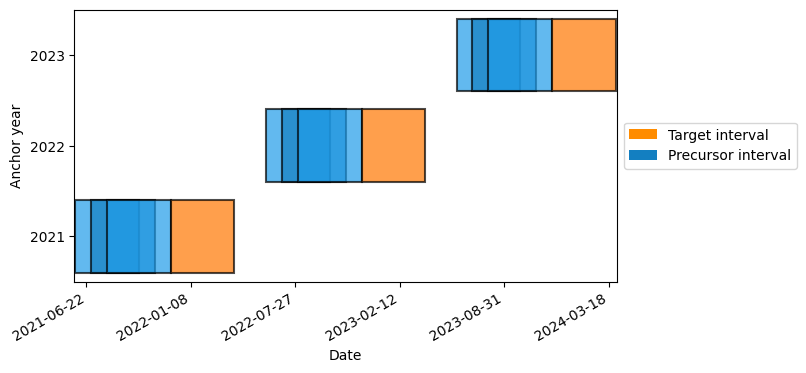

In [209]:
cal.visualize()

In [72]:
# How to set up the crossvalidation if the length of the data changes per predictor, and with the shortest being too short
# Model agnostic, non-performance-based, also needs CV?

### Model specific selection
Needs wrapping in SequentialFeatureSelector or RFE

In [ ]:
# Accepts any scoring function, so can be combined with multiple trials and averaging.

def scoring_func(model, X:np.ndarray, y:np.ndarray) -> tuple[np.ndarray,np.ndarray]:
    """ wrapping crossvalidation, repeated model fitting"""
    pass

In [ ]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10)
        )

    def forward(self, x):
        logits = self.linear_relu_stack(x)
        return logits

In [ ]:
model = NeuralNetwork().to('cuda')

In [ ]:
model(torch.randn((784,)).to('cuda'))